### 🤖 What are Multi-Agent RAG Systems?
A Multi-Agent RAG System splits the RAG pipeline into multiple specialized agents — each responsible for a specific role — and enables them to collaborate on a single query or task.

## 📋 Multi-Agent Network RAG System with LangGraph
Project Overview

A beginner-friendly Retrieval-Augmented Generation (RAG) system that uses a multi-agent architecture to intelligently answer questions from your documents. Built with LangGraph v0.3 for workflow orchestration and OpenAI for language understanding.

What It Does

Transforms your documents (PDFs, text files) into a searchable knowledge base that can answer questions intelligently using AI. Simply upload documents and ask questions in natural language - the system finds relevant information and generates comprehensive answers.
Key Features

- 📚 Multi-Format Support: Handles PDF and text documents
- 🤖 3-Agent Architecture: Specialized agents for document processing, retrieval, and answer generation
- 🔍 Smart Search: Vector-based semantic search finds relevant information
- 💬 Natural Language Q&A: Ask questions in plain English


## Setup and Import Libraries

In [1]:
import os
from typing import Annotated, Literal
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.agents import Tool
from langchain_community.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.types import Command
from dotenv import load_dotenv


In [2]:
load_dotenv()

True

In [3]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o-mini")

## Create Tools

### Tavily Tool

In [5]:
tavily_tool = TavilySearch(max_results=5)

### Retriever Tool

In [6]:
def make_retriever_tool_from_text(file, name, description, chunk_size=500, chunk_overlap=50):
    documents = TextLoader(file_path=file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap).split_documents(documents=documents)
    
    vector_store = FAISS.from_documents(
        documents=chunks, 
        embedding=embeddings
    )

    retriever = vector_store.as_retriever()

    def tool_function(query:str) -> str:
        print(f"📚 Using Tool: {name}")
        results = retriever.invoke(input=query)
        return "\n\n".join(result.page_content for result in results)
    
    return Tool(name=name, description=description, func=tool_function)


internal_document_tool = make_retriever_tool_from_text(
    file="internal_docs.txt",
    name="InternalResearchNotes", 
    description="Search internal research notes for experimental results"
)

internal_document_tool

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_function at 0x000002A62E9D1A80>)

## Creating Node

In [7]:
def get_next_node(last_message: BaseMessage, goto_node: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto_node

In [8]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

### Research Agent

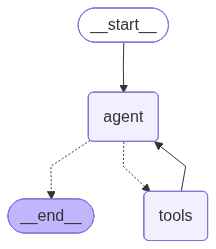

In [9]:
research_agent = create_react_agent(
    model=llm,
    tools=[internal_document_tool, tavily_tool],
    prompt=make_system_prompt(suffix="""You can only do research. Use the tool that you are binded with, you can use both of them
    You are working with a content writer colleague.""")
)

research_agent

### Research Node

In [10]:
def research_node(state:MessagesState) -> Command[Literal["blog_generator", END]]:
    result = research_agent.invoke(input=state)
    goto_node = get_next_node(last_message=result["messages"][-1], goto_node="blog_generator")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content,
        name="researcher"
    )

    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto_node,
    )

### Blog Writer Agent

In [11]:
blog_agent = create_react_agent(
    model=llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        suffix="You can only write a detailed blog. You are working with a researcher colleague."
    )
)

### Blog Writer Node

In [12]:
def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = blog_agent.invoke(input=state)
    goto_node = get_next_node(last_message=result["messages"][-1], goto_node="researcher")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, 
        name="blog_generator"
    )

    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto_node,
    )

## Create Graph

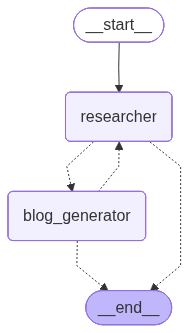

In [13]:
builder = StateGraph(MessagesState)

# Add Nodes
builder.add_node(node="researcher", action=research_node)
builder.add_node(node="blog_generator", action=blog_node)

# Add Edges
builder.add_edge(start_key=START, end_key="researcher")

# Compile Graph
graph = builder.compile()
graph

In [14]:
response = graph.invoke({"messages":"Write a detailed blog on transformer variants in production deployments"})

📚 Using Tool: InternalResearchNotes


In [15]:
response["messages"][-1].content

'FINAL ANSWER\n\n### Transformer Variants in Production Deployments\n\nThe deployment of transformer models in production environments is a pivotal aspect of harnessing their potential for various applications, including natural language processing, computer vision, and more. As organizations increasingly adopt machine learning, understanding the variants of transformer models and their specific deployment strategies becomes essential. This blog post explores several notable transformer variants, their deployment considerations, and best practices to ensure successful implementation.\n\n#### Notable Transformer Variants\n\n1. **BERT (Bidirectional Encoder Representations from Transformers)**:\n   - BERT revolutionized NLP by using bidirectional training, allowing the model to consider the context of words from both left and right.\n   - **Use Cases**: Question answering, sentiment analysis, and language translation.\n\n2. **GPT (Generative Pre-trained Transformer)**:\n   - GPT employs 